# Co-Infection Risk Prediction with Machine Learning
This project predicts the risk levels of co-infection with MRSA and flu using machine learning approaches based on simulation-generated data from our custom SIR-SIS model. The model identifies factors contributing co-infection risk and can provide actionable insights through scenario-based risk evalauation.

This code includes:

1. Preprocessing simulation data for machine learning.

2. Training and evaluating Random Forest, Logistic Regression, and XGBoost models.

3. Visualizing feature importance and model predictions.

4. Generating controlled scenarios for risk level predictions.

In [301]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, make_scorer, recall_score

## Data Preprocessing

In [6]:
# load data files
file_50 = pd.read_csv("/Users/asmakhimani/Downloads/full_results_50_runs.csv")
file_500 = pd.read_csv("/Users/asmakhimani/Downloads/full_results_500_runs.csv")

In [7]:
# renumber simulations so that simulations in the 50 simulation file are numbered 501–550
file_50["Simulation"] += 500
file_50.head(40)

,Simulation,Beta_flu,Beta_mrsa,Delta,Initial_infected_flu,Initial_infected_mrsa,Contact Number,Day,S,I_flu,I_mrsa,I_both,I_mrsa_R_flu,S_mrsa_R_flu
0,501,0.3,0.05,0.6,2,2,10,0,47,2,2,0,0,0
1,501,0.3,0.05,0.6,2,2,10,1,29,13,1,8,0,0
2,501,0.3,0.05,0.6,2,2,10,2,9,26,1,12,0,3
3,501,0.3,0.05,0.6,2,2,10,3,0,31,1,14,0,5
4,501,0.3,0.05,0.6,2,2,10,4,0,26,1,16,1,7
5,501,0.3,0.05,0.6,2,2,10,5,0,23,1,17,1,9
6,501,0.3,0.05,0.6,2,2,10,6,0,21,1,18,3,8
7,501,0.3,0.05,0.6,2,2,10,7,0,18,1,18,3,11
8,501,0.3,0.05,0.6,2,2,10,8,0,18,1,18,5,9
9,501,0.3,0.05,0.6,2,2,10,9,0,17,1,18,4,11


In [9]:
# combine datasets 
combined_data = pd.concat([file_500, file_50], ignore_index=True)

# how many rows and columns
print("shape:", combined_data.shape)

# how many simulations
print("simulations:", combined_data["Simulation"].nunique())

shape: (17050, 14)
simulations: 550


In [14]:
# check that each simulation has 31 rows
rows_per_simulation = combined_data.groupby("Simulation")["Day"].count()
print("rows per simulation:")
print(rows_per_simulation.value_counts())

rows per simulation:
Day
31    550
Name: count, dtype: int64


In [15]:
# check for duplicate simulation-day pairs
duplicates = combined_data.duplicated(subset=["Simulation", "Day"])
print(f"duplicate simulation-day pairs: {duplicates.sum()}")

duplicate simulation-day pairs: 0


<Axes: title={'center': 'Distribution of I_both'}, ylabel='Frequency'>

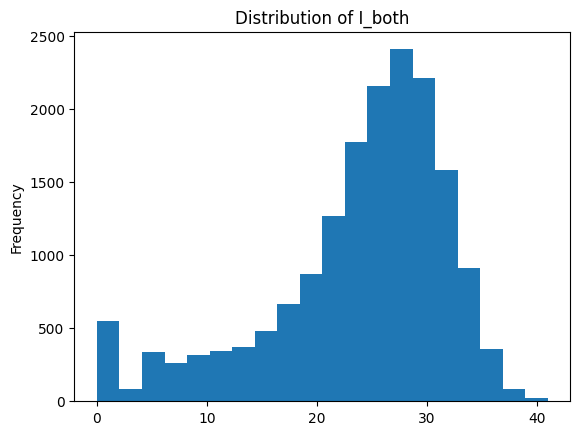

In [16]:
# inspect co infection values
combined_data['I_both'].describe()
combined_data['I_both'].plot(kind='hist', bins=20, title="Distribution of I_both")

In [37]:
# calculate percentiles for I_both
low_threshold = combined_data['I_both'].quantile(0.33)
medium_threshold = combined_data['I_both'].quantile(0.66)

In [38]:
# display thresholds
print(f"Low Risk Threshold: <= {low_threshold}")
print(f"Medium Risk Threshold: {low_threshold} - {medium_threshold}")
print(f"High Risk Threshold: > {medium_threshold}")

Low Risk Threshold: <= 23.0
Medium Risk Threshold: 23.0 - 28.0
High Risk Threshold: > 28.0


In [39]:
# assign risk levels based on thresholds
bins = [0, low_threshold, medium_threshold, combined_data['I_both'].max()]
labels = ['low', 'medium', 'high']

combined_data['risk_level'] = pd.cut(
    combined_data['I_both'], bins=bins, labels=labels, include_lowest=True
)

# verify distribution of risk levels
print(combined_data['risk_level'].value_counts())

risk_level
low       6381
medium    5504
high      5165
Name: count, dtype: int64


## Feataure Engineering and Selection

In [120]:
## create prevalence features

# calculate prevalence
# combined_data['flu_prevalence'] = combined_data['I_flu'] / 51
# combined_data['mrsa_prevalence'] = combined_data['I_mrsa'] / 51
combined_data['flu_prevalence'] = (combined_data['I_flu'] + combined_data['I_both']) / 51
combined_data['mrsa_prevalence'] = (combined_data['I_mrsa'] + combined_data['I_both']) / 51
combined_data['both_prevalence'] = combined_data['I_both'] / 51


# check new features
combined_data[['Day', 'I_flu', 'flu_prevalence', 'I_mrsa', 'mrsa_prevalence', 'I_both', 'both_prevalence']].head()

,Day,I_flu,flu_prevalence,I_mrsa,mrsa_prevalence,I_both,both_prevalence
0,0,2,0.039216,2,0.039216,0,0.000000
1,1,16,0.450980,2,0.176471,7,0.137255
2,2,32,0.823529,2,0.235294,10,0.196078
3,3,29,0.862745,1,0.313725,15,0.294118
4,4,25,0.823529,1,0.352941,17,0.333333


In [121]:
# summary statistics for prevalence
print(combined_data[['flu_prevalence', 'mrsa_prevalence', 'both_prevalence']].describe())

       flu_prevalence  mrsa_prevalence  both_prevalence
count    17050.000000     17050.000000     17050.000000
mean         0.625203         0.474208         0.465020
std          0.168265         0.153022         0.159392
min          0.039216         0.039216         0.000000
25%          0.529412         0.411765         0.392157
50%          0.627451         0.509804         0.509804
75%          0.745098         0.588235         0.568627
max          1.000000         0.803922         0.803922


In [122]:
## create rate of change features

combined_data['D_flu_prevalence'] = combined_data['flu_prevalence'].diff().fillna(0)
combined_data['D_mrsa_prevalence'] = combined_data['mrsa_prevalence'].diff().fillna(0)
combined_data['D_both_prevalence'] = combined_data['both_prevalence'].diff().fillna(0)

# check rate of change features
print(combined_data[['D_flu_prevalence', 'D_mrsa_prevalence', 'D_both_prevalence']].head(10))

   D_flu_prevalence  D_mrsa_prevalence  D_both_prevalence
0          0.000000           0.000000           0.000000
1          0.411765           0.137255           0.137255
2          0.372549           0.058824           0.058824
3          0.039216           0.078431           0.098039
4         -0.039216           0.039216           0.039216
5          0.000000           0.058824           0.058824
6         -0.019608           0.078431           0.078431
7          0.000000           0.000000           0.000000
8          0.000000           0.019608           0.019608
9         -0.058824           0.039216           0.039216


In [123]:
## create peak metrics: 1. keep all peak rows and 2. create a secondary feature for the first peak

# find peak prevalence for each metric
peak_flu_prevalence = combined_data['flu_prevalence'].max()
peak_mrsa_prevalence = combined_data['mrsa_prevalence'].max()
peak_both_prevalence = combined_data['both_prevalence'].max()

# print peak values 
print(f"peak flu prevalence: {peak_flu_prevalence}")
print(f"peak mrsa prevalence: {peak_mrsa_prevalence}")
print(f"peak coinfection prevalence: {peak_both_prevalence}")

# add binary columns for is_peak 
combined_data['is_peak_flu'] = (combined_data['flu_prevalence'] == peak_flu_prevalence).astype(int)
combined_data['is_peak_mrsa'] = (combined_data['mrsa_prevalence'] == peak_mrsa_prevalence).astype(int)
combined_data['is_peak_both'] = (combined_data['both_prevalence'] == peak_both_prevalence).astype(int)

# add secondary feature for the first peak
combined_data['is_first_peak_flu'] = 0
combined_data['is_first_peak_mrsa'] = 0
combined_data['is_first_peak_both'] = 0

# get the first peak timestep for each
first_peak_flu_timestep = combined_data[combined_data['flu_prevalence'] == peak_flu_prevalence].index[0]
first_peak_mrsa_timestep = combined_data[combined_data['mrsa_prevalence'] == peak_mrsa_prevalence].index[0]
first_peak_both_timestep = combined_data[combined_data['both_prevalence'] == peak_both_prevalence].index[0]

# flag the first peaks
combined_data.loc[first_peak_flu_timestep, 'is_first_peak_flu'] = 1
combined_data.loc[first_peak_mrsa_timestep, 'is_first_peak_mrsa'] = 1
combined_data.loc[first_peak_both_timestep, 'is_first_peak_both'] = 1

# check first peaks were flagged correctly
print(combined_data[combined_data['is_first_peak_flu'] == 1][['Day', 'flu_prevalence', 'is_first_peak_flu']])
print(combined_data[combined_data['is_first_peak_mrsa'] == 1][['Day', 'mrsa_prevalence', 'is_first_peak_mrsa']])
print(combined_data[combined_data['is_first_peak_both'] == 1][['Day', 'both_prevalence', 'is_first_peak_both']])


peak flu prevalence: 1.0
peak mrsa prevalence: 0.803921568627451
peak coinfection prevalence: 0.803921568627451
       Day  flu_prevalence  is_first_peak_flu
13426    3             1.0                  1
      Day  mrsa_prevalence  is_first_peak_mrsa
8976   17         0.803922                   1
      Day  both_prevalence  is_first_peak_both
8976   17         0.803922                   1


## Train-Test Split

In [277]:
# features and target
features = [
    'flu_prevalence', 'mrsa_prevalence',
    'D_flu_prevalence', 'D_mrsa_prevalence',
    'is_peak_flu', 'is_peak_mrsa',
    'is_first_peak_flu', 'is_first_peak_mrsa'
]

target = 'risk_level'

In [278]:
# get unique simulation ids
unique_simulations = combined_data["Simulation"].unique()

# split simulation ids into training and testing sets
train_simulations, test_simulations = train_test_split(
    unique_simulations, test_size=0.2, random_state=42
)

# filter data based on simulations
train_data = combined_data[combined_data["Simulation"].isin(train_simulations)]
test_data = combined_data[combined_data["Simulation"].isin(test_simulations)]

# check split
print(f"training data shape: {train_data.shape}")
print(f"testing data shape: {test_data.shape}")
print(f"overlap in simulations: {set(train_simulations) & set(test_simulations)}")  # empty

training data shape: (13640, 27)
testing data shape: (3410, 27)
overlap in simulations: set()


In [279]:
# number of cases for each risk level in each set
print("training risk level distribution:")
print(train_data["risk_level"].value_counts())

print("testing risk level distribution:")
print(test_data["risk_level"].value_counts())

training risk level distribution:
risk_level
low       5154
medium    4309
high      4177
Name: count, dtype: int64
testing risk level distribution:
risk_level
low       1227
medium    1195
high       988
Name: count, dtype: int64


In [280]:
# separate features and target
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [281]:
# scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert scaled data back to DataFrame for compatibility with feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)

## Random Forest 

In [282]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [283]:
# train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [284]:
# predict on the testing set
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

# evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(
    y_test, 
    y_prob, 
    multi_class='ovr',  
    average='weighted'
)

print("Weighted AUC Score:", auc)

Accuracy: 0.9736070381231672
Confusion Matrix:
 [[ 975    0   13]
 [   0 1212   15]
 [  42   20 1133]]
Classification Report:
               precision    recall  f1-score   support

        high       0.96      0.99      0.97       988
         low       0.98      0.99      0.99      1227
      medium       0.98      0.95      0.96      1195

    accuracy                           0.97      3410
   macro avg       0.97      0.97      0.97      3410
weighted avg       0.97      0.97      0.97      3410

Weighted AUC Score: 0.9981021669984409


In [285]:
## random serach 

# parameter grid
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# custom scoring function for high-risk recall
recall_high_scorer = make_scorer(recall_score, average=None, labels=['high'])

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf,
    param_distributions,
    n_iter=20,
    cv=3,
    scoring='recall_macro',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Macro Recall:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimato

In [286]:
# train rf model with best parameters
optimized_rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=50,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=10,
    random_state=42
)
optimized_rf.fit(X_train, y_train)

# predict and evaluate
y_pred = optimized_rf.predict(X_test)
y_prob = optimized_rf.predict_proba(X_test)

In [287]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# multi-class auc
auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
print("Weighted AUC Score:", auc)

Confusion Matrix:
 [[ 980    0    8]
 [   0 1204   23]
 [  46    4 1145]]
Classification Report:
               precision    recall  f1-score   support

        high       0.96      0.99      0.97       988
         low       1.00      0.98      0.99      1227
      medium       0.97      0.96      0.97      1195

    accuracy                           0.98      3410
   macro avg       0.98      0.98      0.98      3410
weighted avg       0.98      0.98      0.98      3410

Weighted AUC Score: 0.9984822217649094


In [288]:
recall = recall_score(y_test, y_pred, average=None, labels=['low', 'medium', 'high'])
print("Recall for Each Class:", recall)
print("Recall for High Risk:", recall[2])

Recall for Each Class: [0.98125509 0.958159   0.99190283]
Recall for High Risk: 0.9919028340080972


[[ 980    0    8]
 [   0 1204   23]
 [  46    4 1145]]


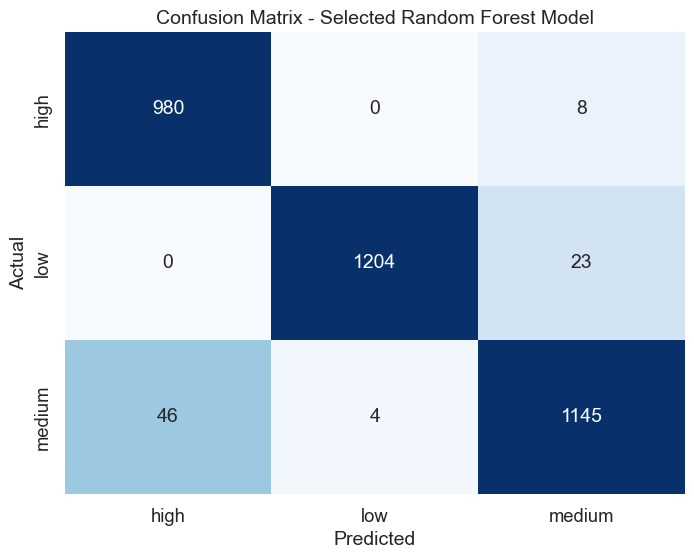

In [292]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 

# plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['high', 'low', 'medium'], 
            yticklabels=['high', 'low', 'medium'], 
            annot_kws={"size": 14}, vmin=0, vmax=cm.max() * 0.1)

# add labels, title, and show the plot
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix - Selected Random Forest Model', fontsize=14)
plt.savefig('confusion_matrix_rf_epi.png')
plt.show()

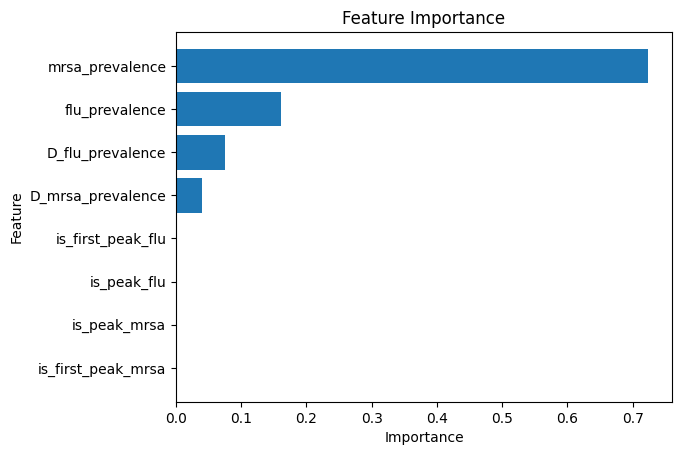

In [136]:
# feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': optimized_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

Prevalence of Flu: 0.1612
Prevalence of MRSA: 0.7241
Rate of Change in Flu Prevalence: 0.0748
Rate of Change in MRSA Prevalence: 0.0398
Peak Flu Prevalence: 0.0000
Peak MRSA Prevalence: 0.0000
First Peak of Flu Prevalence: 0.0000
First Peak of MRSA Prevalence: 0.0000


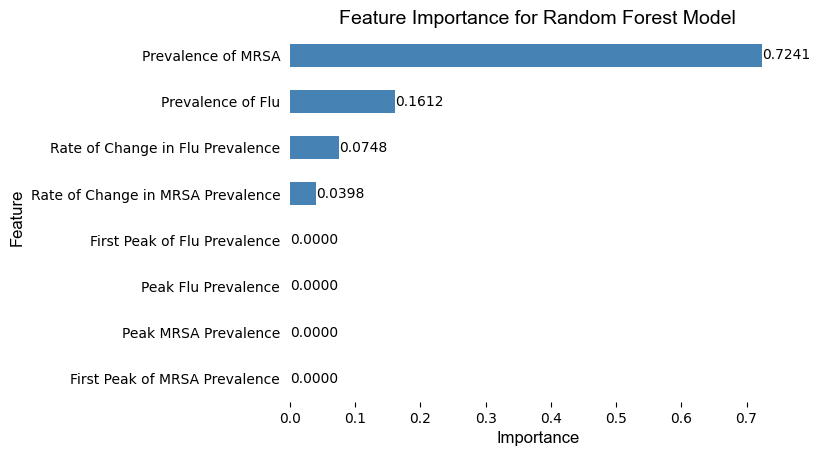

In [274]:
# plotting feature importances
feature_importances = pd.Series(optimized_rf.feature_importances_, index=X_train.columns)

# dictionary to rename features
name_dict = {
    'mrsa_prevalence': 'Prevalence of MRSA',
    'flu_prevalence': 'Prevalence of Flu',
    'D_flu_prevalence': 'Rate of Change in Flu Prevalence',
    'D_mrsa_prevalence': 'Rate of Change in MRSA Prevalence',
    'is_first_peak_flu': 'First Peak of Flu Prevalence',
    'is_peak_flu': 'Peak Flu Prevalence',
    'is_peak_mrsa': 'Peak MRSA Prevalence',
    'is_first_peak_mrsa': 'First Peak of MRSA Prevalence'
}

# print out importance data weights 
for feature, importance in feature_importances.items():
    print(f'{name_dict.get(feature)}: {importance:.4f}')

# sort feature importances by importance (descending order)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# apply dictionary to y-axis labels
new_y_labels = [name_dict[col] if col in name_dict else col for col in feature_importances_sorted.index]

# plotting the top features
ax = feature_importances_sorted.plot(kind='barh', color='#4682B4')

# highest importance feature on top
plt.gca().invert_yaxis()

# set font
font = {'fontname': 'Arial'}

# add axis labels
plt.xlabel('Importance', **font, fontsize=12)
plt.ylabel('Feature', **font, fontsize=12)

# add title
ax.set_title('Feature Importance for Random Forest Model', loc='center', **font, fontsize=14)

# remove borders
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# remove y-axis ticks
ax.tick_params(axis='y', which='both', left=False)
    
# rename the y-axis labels
ax.set_yticklabels(new_y_labels)

# add data weights
for i, value in enumerate(feature_importances_sorted):
    ax.text(value, i, f'{value:.4f}', color='black', va='center')

# save as .png file
plt.savefig('feature_importance_rf_epi.png', bbox_inches='tight')
plt.show()

In [137]:
# see summary stats of most important features
print(combined_data[['flu_prevalence', 'mrsa_prevalence', 'D_flu_prevalence', 'D_mrsa_prevalence']].describe())

       flu_prevalence  mrsa_prevalence  D_flu_prevalence  D_mrsa_prevalence
count    17050.000000     17050.000000      17050.000000       17050.000000
mean         0.625203         0.474208          0.000022           0.000022
std          0.168265         0.153022          0.130637           0.091278
min          0.039216         0.039216         -0.666667          -0.666667
25%          0.529412         0.411765         -0.019608           0.000000
50%          0.627451         0.509804          0.000000           0.000000
75%          0.745098         0.588235          0.000000           0.019608
max          1.000000         0.803922          0.411765           0.235294


In [302]:
# save optimized rf model
model_filename = "random_forest_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(optimized_rf, file)
print(f"Model saved to {model_filename}")

Model saved to random_forest_model.pkl


## Scenario-based Risk Evaluation

In [186]:
# scenario ranges for selected features
mrsa_prevalence_range = np.linspace(0.35, 0.6, 10)
flu_prevalence_range = np.linspace(0.5, 0.9, 10)  

# df combinations of these ranges
scenarios = pd.DataFrame(
    [
        (mrsa, flu)
        for mrsa in mrsa_prevalence_range
        for flu in flu_prevalence_range
    ],
    columns=["mrsa_prevalence", "flu_prevalence"]
)

# add static values for other features
scenarios["D_flu_prevalence"] = 0.01 
scenarios["D_mrsa_prevalence"] = 0.01
scenarios["is_peak_flu"] = 1 
scenarios["is_peak_mrsa"] = 1
scenarios["is_first_peak_flu"] = 0
scenarios["is_first_peak_mrsa"] = 0

print("Generated Scenarios:", scenarios.shape)

Generated Scenarios: (100, 8)


In [187]:
# features used during training
trained_features = optimized_rf.feature_names_in_
print("Features used in training:", trained_features)

Features used in training: ['flu_prevalence' 'mrsa_prevalence' 'D_flu_prevalence' 'D_mrsa_prevalence'
 'is_peak_flu' 'is_peak_mrsa' 'is_first_peak_flu' 'is_first_peak_mrsa']


In [188]:
# reorder columns to match training features
scenarios_aligned = scenarios[trained_features]

In [189]:
# predict risk levels
scenarios_aligned["predicted_risk"] = optimized_rf.predict(scenarios_aligned[trained_features])

# predict probabilities
proba = optimized_rf.predict_proba(scenarios_aligned[trained_features])
scenarios_aligned["high_risk_probability"] = proba[:, 0]
scenarios_aligned["low_risk_probability"] = proba[:, 1]
scenarios_aligned["medium_risk_probability"] = proba[:, 2]

# print predictions
print(scenarios_aligned.head())

   flu_prevalence  mrsa_prevalence  D_flu_prevalence  D_mrsa_prevalence  \
0        0.500000             0.35              0.01               0.01   
1        0.544444             0.35              0.01               0.01   
2        0.588889             0.35              0.01               0.01   
3        0.633333             0.35              0.01               0.01   
4        0.677778             0.35              0.01               0.01   

   is_peak_flu  is_peak_mrsa  is_first_peak_flu  is_first_peak_mrsa  \
0            1             1                  0                   0   
1            1             1                  0                   0   
2            1             1                  0                   0   
3            1             1                  0                   0   
4            1             1                  0                   0   

  predicted_risk  high_risk_probability  low_risk_probability  \
0            low               0.000000              0.96

/var/folders/c1/x1l_10ys5kvbrvtgrf_hm0c80000gn/T/ipykernel_42572/235164463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenarios_aligned["predicted_risk"] = optimized_rf.predict(scenarios_aligned[trained_features])
/var/folders/c1/x1l_10ys5kvbrvtgrf_hm0c80000gn/T/ipykernel_42572/235164463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenarios_aligned["high_risk_probability"] = proba[:, 0]
/var/folders/c1/x1l_10ys5kvbrvtgrf_hm0c80000gn/T/ipykernel_42572/235164463.py:7: SettingWithCopyWarning: 

In [190]:
# get value counts for predicted risk levels
risk_counts = scenarios_aligned["predicted_risk"].value_counts()
print("risk level counts:\n", risk_counts)

Risk Level Counts:
 predicted_risk
medium    43
low       41
high      16
Name: count, dtype: int64


In [192]:
# filter high-risk scenarios
high_risk_scenarios = scenarios_aligned[scenarios_aligned["predicted_risk"] == "high"]
print("high-risk scenarios:\n", high_risk_scenarios)

High-Risk Scenarios:
     flu_prevalence  mrsa_prevalence  D_flu_prevalence  D_mrsa_prevalence  \
82        0.588889         0.572222              0.01               0.01   
83        0.633333         0.572222              0.01               0.01   
84        0.677778         0.572222              0.01               0.01   
85        0.722222         0.572222              0.01               0.01   
86        0.766667         0.572222              0.01               0.01   
87        0.811111         0.572222              0.01               0.01   
88        0.855556         0.572222              0.01               0.01   
89        0.900000         0.572222              0.01               0.01   
92        0.588889         0.600000              0.01               0.01   
93        0.633333         0.600000              0.01               0.01   
94        0.677778         0.600000              0.01               0.01   
95        0.722222         0.600000              0.01             

In [303]:
# Save scenario predictions to a CSV file
predictions_filename = "high_risk_scenario_predictions.csv"
high_risk_scenarios.to_csv(predictions_filename, index=False)
print(f"High Risk Scenario predictions saved to {predictions_filename}")

High Risk Scenario predictions saved to high_risk_scenario_predictions.csv


## Logistic Regression

In [295]:
lr = LogisticRegression(multi_class='multinomial', random_state=42)

In [296]:
# parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'], 
    'solver': ['saga', 'lbfgs', 'liblinear'],
    'max_iter': [100, 200, 500, 1000], 
}

# random search
random_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_grid,
    n_iter=50, 
    scoring='recall_macro', 
    cv=5,  
    verbose=1,
    random_state=42,
    n_jobs=-1 
)

In [297]:
# train
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(multi_class='multinomial',
                                                random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'max_iter': [100, 200, 500, 1000],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['saga', 'lbfgs',
                                                   'liblinear']},
                   random_state=42, scoring='recall_macro', verbose=1)

In [298]:
# print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': 1}
Best Score: 0.9641051874147578


In [299]:
# evaluate best parameters on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("weighted auc score:")
print(roc_auc_score(y_test, y_prob, multi_class='ovr'))

Classification Report:
               precision    recall  f1-score   support

        high       1.00      0.18      0.31       988
         low       0.57      1.00      0.73      1227
      medium       0.26      0.23      0.25      1195

    accuracy                           0.50      3410
   macro avg       0.61      0.47      0.43      3410
weighted avg       0.59      0.50      0.44      3410

confusion matrix:
[[ 182    0  806]
 [   0 1227    0]
 [   0  915  280]]
weighted auc score:
0.8672180132259819


## Gradiant Boosting

In [219]:
# convert classes to numerical values
label_encoder = LabelEncoder()

# encode y_train and y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# print classes
print("Class Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Class Mapping: {'high': np.int64(0), 'low': np.int64(1), 'medium': np.int64(2)}


In [221]:
xgb = XGBClassifier(
    random_state=42
)

# train
xgb.fit(X_train, y_train_encoded)

# predict and evaluate
y_pred_xgb_encoded = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)

# decode predictions back to original labels
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("Weighted AUC Score:")
print(roc_auc_score(y_test_encoded, y_prob_xgb, multi_class='ovr', average='weighted'))

XGBoost Classification Report:
              precision    recall  f1-score   support

        high       0.96      0.98      0.97       988
         low       0.99      0.98      0.99      1227
      medium       0.97      0.95      0.96      1195

    accuracy                           0.97      3410
   macro avg       0.97      0.97      0.97      3410
weighted avg       0.97      0.97      0.97      3410

Confusion Matrix:
[[ 972    0   16]
 [   0 1207   20]
 [  41   15 1139]]
Weighted AUC Score:
0.998568874435948


In [225]:
param_distributions = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
}

xgb_tuned = XGBClassifier(random_state=42)

# random search
random_search = RandomizedSearchCV(
    xgb_tuned,
    param_distributions,
    n_iter=20,
    scoring='recall_macro',
    cv=5,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train_encoded)
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   0.1s
[CV

In [226]:
# retrain XGB with the best parameters
xgb_optimized = XGBClassifier(
    subsample=0.8,
    n_estimators=50,
    max_depth=5,
    learning_rate=0.01,
    random_state=42
)

xgb_optimized.fit(X_train, y_train_encoded)

# predict and evaluate
y_pred_optimized = xgb_optimized.predict(X_test)
y_prob_optimized = xgb_optimized.predict_proba(X_test)

# decode predictions back to original labels
y_pred_optimized_labels = label_encoder.inverse_transform(y_pred_optimized)

# evaluate
print("Optimized XGBoost Classification Report:")
print(classification_report(y_test, y_pred_optimized_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimized_labels))

print("Weighted AUC Score:")
print(roc_auc_score(y_test_encoded, y_prob_optimized, multi_class='ovr', average='weighted'))

Optimized XGBoost Classification Report:
              precision    recall  f1-score   support

        high       0.96      0.98      0.97       988
         low       0.99      0.98      0.99      1227
      medium       0.96      0.96      0.96      1195

    accuracy                           0.97      3410
   macro avg       0.97      0.97      0.97      3410
weighted avg       0.97      0.97      0.97      3410

Confusion Matrix:
[[ 966    0   22]
 [   0 1207   20]
 [  39   10 1146]]
Weighted AUC Score:
0.9986549909996407
